# Analysis SUSO outreach letters

This notebook analyzes the automated letters sent to a random assignment of SUSO-eligible families increase the rate at which those families engage with SUSO CBOs. 

**Dependent variables. **
The dependent variable is the binary flag in ETO indicating whether a CBO has obtained written consent to “engage” a family in order to provide support. Engagement occurs when a guardian in a family provides written consent for CBO assistance. The engagement rate across the entire SUSO program was 7.4% in 2016. 

**Primary Hypotheses.  **
The primary hypothesis is that families who receive a letter will be more likely to “engage” with the CBO to seek services than those who do not receive a letter.  

**Statistical analysis. **
We will employ a standard Bayesian analysis to test the hypothesis that subjects in the treatment arm (receiving a letter) are more likely to engage with CBOs than subjects in the control arm (not receiving a letter). This analysis is described in Appendix B. We will also estimate the size of the effect including the distribution of uncertainty around that effect size. We will estimate the range of odds of our model being correct across 10,000 simulations from the posterior. See Appendix B. 

**Secondary Analyses/Exploratory Analyses. **
There may be heterogeneous treatment effects across CBOs and schools. Although the sample is likely too small, we will attempt to assess such effects. 

If attendance data becomes available over the course of the pilot, we will add attendance as another dependent variable. 

See OSF registration here: https://docs.google.com/document/d/1RiiKCyvuKdHwQCh4UuodwT8DFwJ4_szHAT7IeHISckI/edit#heading=h.v7amrmv0sovo


In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pyproj import CRS
from scipy import stats

%matplotlib inline

pd.set_option("display.max_rows", 500)

from suso import ab_test
from suso.utils import here

In [2]:
DATA_DIR = here("data")
OUTPUT_DIR = here("output")

# load data

Load prior to analysis

In [3]:
df = pd.read_csv(DATA_DIR / "data_for_analysis.csv")
bounced = pd.read_csv(DATA_DIR / "returned_letters.csv")
bounced = bounced.drop_duplicates("CLID", keep="first")

In [4]:
suso = pd.read_csv(DATA_DIR / "suso_participants.csv")
suso["in_suso"] = True

In [5]:
df_suso = df.merge(
    suso[["CLID", "DateEngaged", "DateNotEngaged", "in_suso"]], how="left", on="CLID"
)
print(df_suso.DateEngaged.notnull().sum() / df_suso.shape[0])
print(df_suso.DateNotEngaged.notnull().sum() / df_suso.shape[0])

0.10869565217391304
0.3485273492286115


In [6]:
print(suso.CurrentReferralStatus.value_counts(normalize=True))

Not Engaged    0.891304
Engaged        0.108696
Name: CurrentReferralStatus, dtype: float64


In [7]:
df_suso["engaged_full"] = df_suso.DateEngaged.notnull() | df_suso.engaged

In [8]:
df_suso["referral_dt"] = pd.to_datetime(df_suso.referral_date)
df_suso["engaged_dt"] = pd.to_datetime(df_suso.DateEngaged)

In [9]:
df_suso["days_to_engage"] = (df_suso.engaged_dt - df_suso.referral_dt).dt.days
df_suso["engaged_14days"] = (df_suso.days_to_engage >= -1) & (
    df_suso.days_to_engage <= 14
)

print(df_suso["engaged"].sum())
print(df_suso["engaged_14days"].sum())
print(df_suso["engaged"].sum() / df_suso.shape[0])
print(df_suso["engaged_14days"].sum() / df_suso.shape[0])

150
98
0.10518934081346423
0.06872370266479663


## Test for effect of the letters with strict ITT

In [10]:
def perform_analysis(control_df, treatment_df, analysis_col):
    control_outcome = control_df[analysis_col]
    treatment_outcome = treatment_df[analysis_col]

    print("Number in control:", len(control_outcome))
    print("Number in treatment:", len(treatment_outcome))

    successes_a = control_outcome.sum()
    failures_a = len(control_outcome) - successes_a
    successes_b = treatment_outcome.sum()
    failures_b = len(treatment_outcome) - successes_b

    base_rate = successes_a / len(control_outcome)
    treatment_rate = successes_b / len(treatment_outcome)

    num_participants = len(df_suso)

    print(ab_test.degree_of_certainty(successes_a, failures_a, successes_b, failures_b))

    print("Number control engaged:", successes_a)
    print("Number treatment engaged:", successes_b)

    print("Percent control engaged:", base_rate)
    print("Percent treatment engaged:", treatment_rate)

    return successes_a, failures_a, successes_b, failures_b

In [11]:
perform_analysis(
    df_suso[df_suso.is_treatment == False],
    df_suso[df_suso.is_treatment == True],
    "engaged_full",
)

Number in control: 625
Number in treatment: 649
0.05627680929518467
Number control engaged: 76
Number treatment engaged: 61
Percent control engaged: 0.1216
Percent treatment engaged: 0.09399075500770417


(76, 549, 61, 588)

Number in control: 625
Number in treatment: 649
0.09801971018619943
Number control engaged: 48
Number treatment engaged: 38
Percent control engaged: 0.0768
Percent treatment engaged: 0.05855161787365177


-0.08697459123030216 -0.00024617283970879145


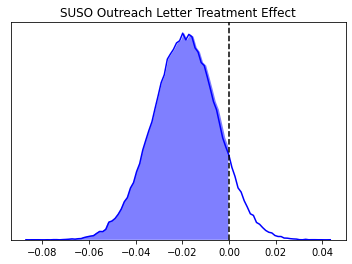

In [12]:
successes_a, failures_a, successes_b, failures_b = perform_analysis(
    df_suso[df_suso.is_treatment == False],
    df_suso[df_suso.is_treatment == True],
    "engaged_14days",
)

size = 100000
beta_c = np.random.beta(successes_a, failures_a, size=size)
beta_t = np.random.beta(successes_b, failures_b, size=size)

posterior = beta_t - beta_c
posterior.sort()

ci95 = posterior[int(len(posterior) * 0.9)]
ci05 = posterior[0]
print(ci05, ci95)

bins = np.linspace(posterior[0], posterior[-1], 101)
bottom95 = bins[:-1] < ci95
top95 = bins[:-1] > ci05
ci_mask = top95 & bottom95

hist, edges = np.histogram(posterior, bins=bins)
plt.plot(bins[:-1], hist, color="blue")
plt.fill_between(
    np.linspace(ci05, ci95, len(hist[ci_mask])),
    np.zeros(len(hist[ci_mask])),
    hist[ci_mask],
    facecolor="blue",
    alpha=0.5,
)
plt.axvline(x=0, linestyle="--", color="black")
plt.ylim([0, 4000])
plt.yticks([])
plt.title("SUSO Outreach Letter Treatment Effect")
plt.savefig(OUTPUT_DIR / "posterior.png", bbox_inches="tight")

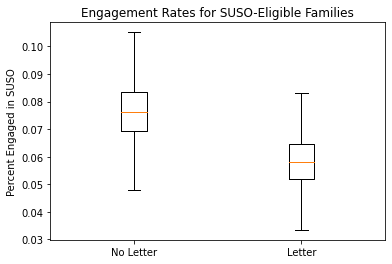

In [13]:
plt.boxplot([beta_c, beta_t], showfliers=False)
plt.xticks([1, 2], ["No Letter", "Letter"])
plt.title("Engagement Rates for SUSO-Eligible Families")
plt.ylabel("Percent Engaged in SUSO")
plt.savefig(OUTPUT_DIR / "engagement_boxplot.png", bbox_inches="tight")

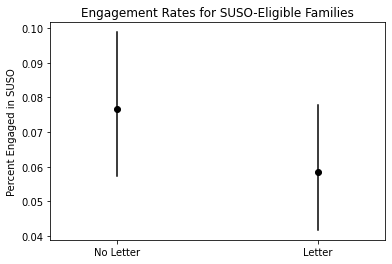

In [14]:
plt.plot([0.2, 0.8], [np.mean(beta_c), np.mean(beta_t)], "o", color="black")
plt.plot(
    [0.2, 0.2],
    [pd.Series(beta_c).mean(), pd.Series(beta_c).quantile(0.975)],
    color="black",
)
plt.plot(
    [0.2, 0.2],
    [pd.Series(beta_c).mean(), pd.Series(beta_c).quantile(0.025)],
    color="black",
)
plt.plot(
    [0.8, 0.8],
    [pd.Series(beta_t).mean(), pd.Series(beta_t).quantile(0.975)],
    color="black",
)
plt.plot(
    [0.8, 0.8],
    [pd.Series(beta_t).mean(), pd.Series(beta_t).quantile(0.025)],
    color="black",
)
plt.xlim(0, 1)
plt.xticks([0.2, 0.8], ["No Letter", "Letter"])
plt.title("Engagement Rates for SUSO-Eligible Families")
plt.ylabel("Percent Engaged in SUSO")
plt.savefig(OUTPUT_DIR / "engagement_rate.png", bbox_inches="tight")

## Taking bounced into consideration

In [15]:
bounced["bounced"] = True
df_bounced = df_suso.merge(bounced, how="left", on="CLID")
print(len(df_suso))
print(len(df_bounced))

1426
1426


In [16]:
# We just exclude bounced letters from the treatment
perform_analysis(
    df_bounced[df_bounced.is_treatment == False],
    df_bounced[(df_bounced.is_treatment == True) & (df_bounced.bounced != True)],
    "engaged_14days",
)

Number in control: 625
Number in treatment: 568
0.08061121277333679
Number control engaged: 48
Number treatment engaged: 32
Percent control engaged: 0.0768
Percent treatment engaged: 0.056338028169014086


(48, 577, 32, 536)

## Taking Mailing Status into Account

In [17]:
perform_analysis(
    df_suso[df_suso.is_treatment == False],
    df_suso[(df_suso.status == "USPS Indicated Delivered") & df.is_treatment == True],
    "engaged_14days",
)

Number in control: 625
Number in treatment: 290
0.22773181779970564
Number control engaged: 48
Number treatment engaged: 18
Percent control engaged: 0.0768
Percent treatment engaged: 0.06206896551724138


(48, 577, 18, 272)

# ouch!

So it looks like there is a very good chance that the letters actually harmed the CBOs ability to engage families. True, the rate is 8.7% v 12.0%, but that's pretty important. Why? There are a bunch of possible explanations, and we should probably explore them each a little for OSF.  Some are just good science checks -- did we get good blocking by CBO?  We'd assume so, since we were trying to block by school.  If we didn't that would be bad. 

# Explore delivery dates

In [18]:
df_suso["delivery_date"] = pd.to_datetime(df_suso["status_datetime"]).dt.round("D")
df_suso["eligibility_date"] = pd.to_datetime(df_suso["referral_date"]).dt.round("D")
df_suso["timeliness"] = df_suso["delivery_date"] - df_suso["eligibility_date"]

In [19]:
toolate_mask = df_suso.timeliness > pd.Timedelta(days=14)
timewarp_mask = df_suso.timeliness < pd.Timedelta(days=0)
delivered_mask = df_suso.status == "USPS Indicated Delivered"

In [20]:
df_suso.loc[toolate_mask, "timeliness"] = pd.Timedelta(days=15)
df_suso.loc[timewarp_mask, "timeliness"] = pd.Timedelta(days=15)

<AxesSubplot:>

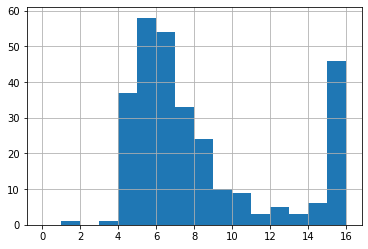

In [21]:
(df_suso.loc[delivered_mask, "timeliness"] / pd.Timedelta(hours=24)).hist(
    bins=np.arange(0, 17, 1)
)

In [22]:
# If your letter arrived too late, just assume you're not part of the treatment
df.loc[timewarp_mask | toolate_mask, "is_treatment"] = False

In [23]:
print(
    df_suso[
        (df_suso.timeliness.dt.days <= 14)
        & (df_suso.status == "USPS Indicated Delivered")
    ].engaged_14days.mean()
)
print(df_suso[df_suso.is_treatment == True].engaged_14days.mean())

0.05737704918032787
0.05855161787365177


<AxesSubplot:>

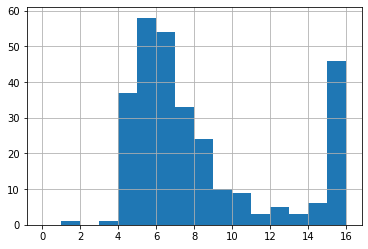

In [24]:
(
    df_suso[df_suso.status == "USPS Indicated Delivered"].timeliness
    / pd.Timedelta(hours=24)
).hist(bins=np.arange(0, 17, 1))

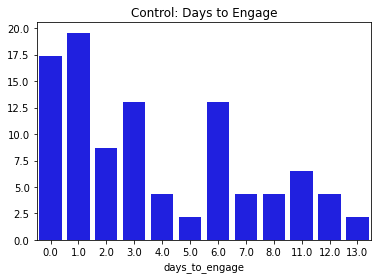

In [25]:
control = df_suso[
    (df_suso.is_treatment == False) & (df_suso.days_to_engage.between(0, 14))
]
pct_engaged = (
    100 * control.groupby("days_to_engage").days_to_engage.count() / control.shape[0]
)
ax = sns.barplot(x=pct_engaged.index, y=pct_engaged.values, color="blue")
ax.set_title("Control: Days to Engage")
plt.savefig(OUTPUT_DIR / "control-days-to-engage.png", bbox_inches="tight")

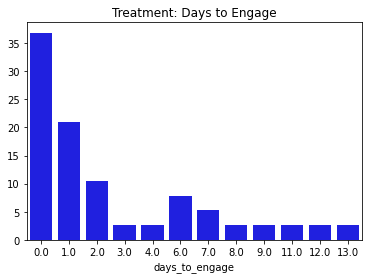

In [26]:
treatment = df_suso[
    (df_suso.is_treatment == True) & (df_suso.days_to_engage.between(0, 14))
]
pct_engaged = (
    100
    * treatment.groupby("days_to_engage").days_to_engage.count()
    / treatment.shape[0]
)
ax = sns.barplot(x=pct_engaged.index, y=pct_engaged.values, color="blue")
ax.set_title("Treatment: Days to Engage")
plt.savefig(OUTPUT_DIR / "treatment-days-to-engage.png", bbox_inches="tight")

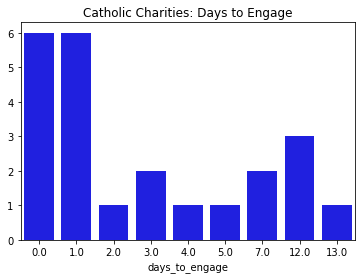

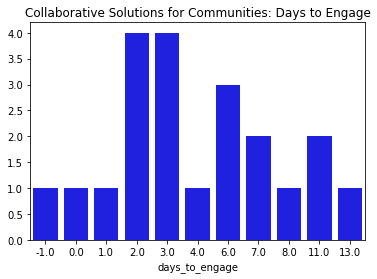

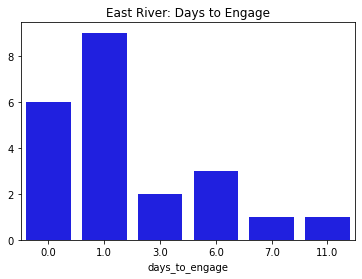

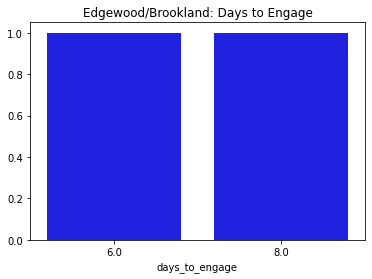

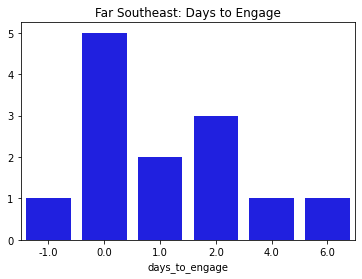

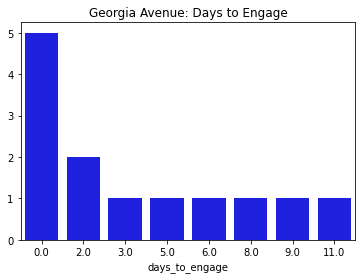

In [27]:
for site in np.sort(df_suso[df_suso.is_treatment.notnull()].site_name.unique()):
    n_gaged = (
        df_suso[(df_suso.site_name == site) & (df_suso.engaged_14days)]
        .groupby("days_to_engage")
        .CLID.count()
    )
    ax = sns.barplot(x=n_gaged.index, y=n_gaged.values, color="blue")
    ax.set_title(site + ": Days to Engage")
    plt.savefig(
        OUTPUT_DIR / (site.replace("/", "") + "-days-to-engage.png"),
        bbox_inches="tight",
    )
    plt.show()

# Explore case management

In [28]:
size = 10000
group = "site_name"
outcome = "engaged_14days"

d = {}

for site in df_suso[df_suso.is_treatment.notnull()][group].unique():
    print("\n" + site)
    df_site = df_suso[df_suso[group] == site].copy()

    cntrl = df_site[df_site.is_treatment == False]
    trtmt = df_site[df_site.is_treatment == True]

    cntrl_a = cntrl[outcome].sum() + 1
    cntrl_b = (len(cntrl) - cntrl_a) + 1
    trtmt_a = trtmt[outcome].sum() + 1
    trtmt_b = (len(trtmt) - trtmt_a) + 1

    print("Number in control:", len(cntrl))
    print("Successes in control:", cntrl_a)
    print("Failures in control:", cntrl_b)
    print("Number in treatment:", len(trtmt))
    print("Successes in treatment:", trtmt_a)
    print("Failures in treatment:", trtmt_b)

    cbeta = np.random.beta(cntrl_a, cntrl_b, size=size)
    tbeta = np.random.beta(trtmt_a, trtmt_b, size=size)

    d[site] = tbeta - cbeta

stats.f_oneway(*d.values())


Edgewood/Brookland
Number in control: 104
Successes in control: 3
Failures in control: 102
Number in treatment: 110
Successes in treatment: 1
Failures in treatment: 110

Collaborative Solutions for Communities
Number in control: 107
Successes in control: 11
Failures in control: 97
Number in treatment: 117
Successes in treatment: 8
Failures in treatment: 110

East River
Number in control: 80
Successes in control: 14
Failures in control: 67
Number in treatment: 84
Successes in treatment: 9
Failures in treatment: 76

Catholic Charities
Number in control: 132
Successes in control: 11
Failures in control: 122
Number in treatment: 125
Successes in treatment: 11
Failures in treatment: 115

Georgia Avenue
Number in control: 96
Successes in control: 8
Failures in control: 89
Number in treatment: 107
Successes in treatment: 7
Failures in treatment: 101

Far Southeast
Number in control: 106
Successes in control: 7
Failures in control: 100
Number in treatment: 106
Successes in treatment: 8
Failur

F_onewayResult(statistic=5612.170855034765, pvalue=0.0)

In [29]:
group = "site_name"
outcome = "engaged_14days"

d = dict()

for site in df_suso[df_suso.is_treatment.notnull()][group].unique():
    print("\n" + site)
    df_site = df_suso[df_suso[group] == site]
    perform_analysis(
        df_site[df_site.is_treatment == False],
        df_site[df_site.is_treatment == True],
        outcome,
    )


Edgewood/Brookland
Number in control: 104
Number in treatment: 110
0.11317587963967145
Number control engaged: 2
Number treatment engaged: 0
Percent control engaged: 0.019230769230769232
Percent treatment engaged: 0.0

Collaborative Solutions for Communities
Number in control: 107
Number in treatment: 117
0.17532237792176228
Number control engaged: 10
Number treatment engaged: 7
Percent control engaged: 0.09345794392523364
Percent treatment engaged: 0.05982905982905983

East River
Number in control: 80
Number in treatment: 84
0.10250597936876421
Number control engaged: 13
Number treatment engaged: 8
Percent control engaged: 0.1625
Percent treatment engaged: 0.09523809523809523

Catholic Charities
Number in control: 132
Number in treatment: 125
0.5519218936740559
Number control engaged: 10
Number treatment engaged: 10
Percent control engaged: 0.07575757575757576
Percent treatment engaged: 0.08

Georgia Avenue
Number in control: 96
Number in treatment: 107
0.3131993780200648
Number cont

## Mapping Site Schools

In [30]:
public_schools = gpd.read_file(
    DATA_DIR / "Public_Schools.geojson", crs=CRS("epsg:4326")
)[["NAME", "ADDRESS", "geometry"]]
charter_schools = gpd.read_file(
    DATA_DIR / "Charter_Schools.geojson", crs=CRS("epsg:4326")
)[["NAME", "ADDRESS", "geometry"]]
schools = pd.concat((public_schools, charter_schools), axis=0)
schools = schools.to_crs(epsg=2248)

In [31]:
school_locations = pd.read_csv(DATA_DIR / "school_locations.csv")
school_locations = schools.merge(
    school_locations, how="inner", left_on="ADDRESS", right_on="address"
)

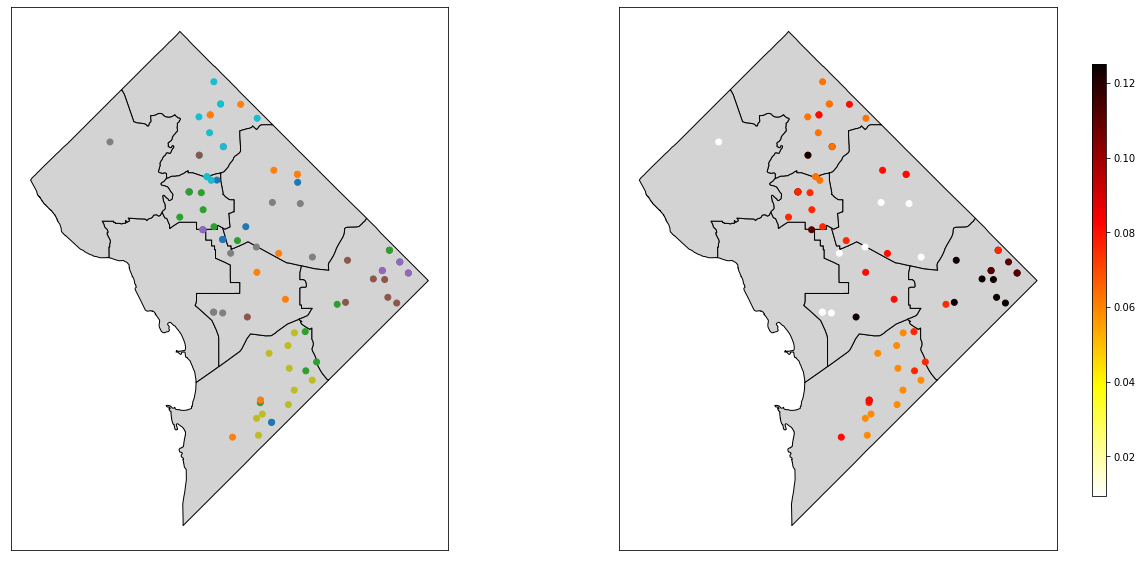

In [32]:
df_site_eng = df_suso.groupby(["site_name"]).engaged_14days.mean().reset_index()
df_sites = df_suso[["site_name", "school_name"]].drop_duplicates()
df_sites = df_sites.merge(df_site_eng, how="left", on="site_name")
geo_sites = school_locations.merge(df_sites, how="left", on="school_name")

wards = gpd.read_file(DATA_DIR / "wards.geojson", crs=CRS("epsg:4326"))
wards = wards.to_crs(epsg=2248)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 10))
wards.plot(ax=ax, color="lightgrey", edgecolor="black")
geo_sites.plot("site_name", ax=ax)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

wards.plot(ax=ax2, color="lightgrey", edgecolor="black")
geo_sites[geo_sites.site_name != "Boys Town"].plot(
    "engaged_14days", cmap="hot_r", ax=ax2
)
ax2.set_aspect("equal")
ax2.set_xticks([])
ax2.set_yticks([])

cax = fig.add_axes([0.9, 0.2, 0.01, 0.6])
sm = plt.cm.ScalarMappable(
    cmap="hot_r",
    norm=plt.Normalize(
        vmin=geo_sites.engaged_14days.min(), vmax=geo_sites.engaged_14days.max()
    ),
)
sm._A = []
fig.colorbar(sm, cax=cax)
cax.tick_params(labelsize=10)

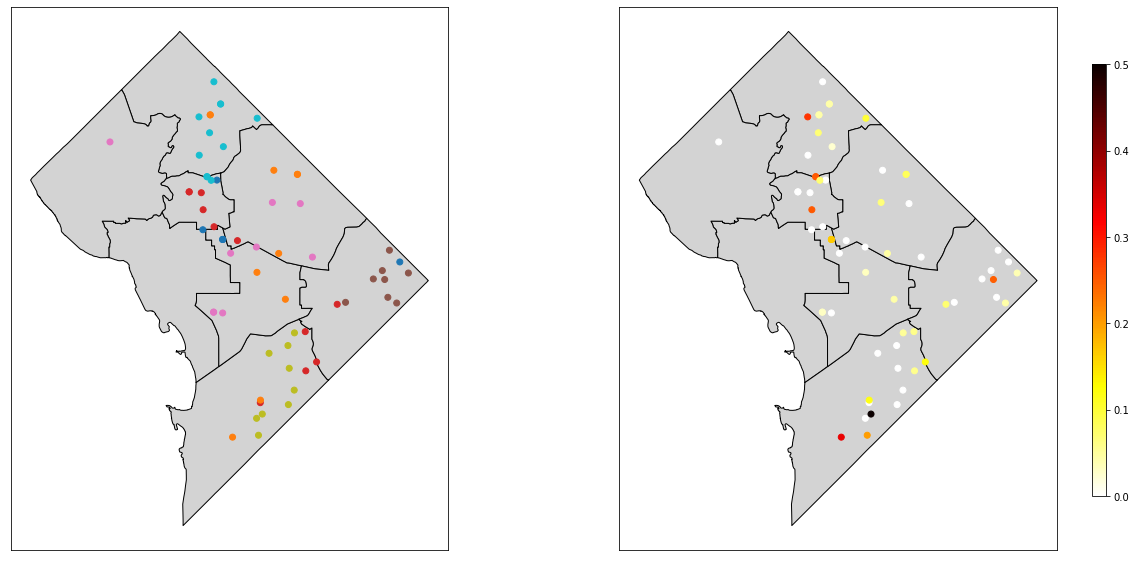

In [33]:
df_site_eng = (
    df_suso.groupby(["site_name", "school_name"]).engaged_14days.mean().reset_index()
)
school_counts = (
    pd.DataFrame(df_suso.groupby(["site_name", "school_name"]).engaged_14days.count())
    .reset_index()
    .rename(columns={"engaged_14days": "counts"})
)
df_sites = df_suso[["site_name", "school_name"]].drop_duplicates()
df_sites = df_sites.merge(df_site_eng, how="left", on=["site_name", "school_name"])
df_sites = df_sites.merge(school_counts, how="left", on=["site_name", "school_name"])
geo_sites = school_locations.merge(df_sites, how="left", on="school_name")

wards = gpd.read_file(DATA_DIR / "wards.geojson", crs=CRS("epsg:4326"))
wards = wards.to_crs(epsg=2248)

to_plot = geo_sites[geo_sites.counts > 2]
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 10))
wards.plot(ax=ax, color="lightgrey", edgecolor="black")
to_plot.plot("site_name", ax=ax)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

wards.plot(ax=ax2, color="lightgrey", edgecolor="black")
to_plot.plot("engaged_14days", cmap="hot_r", ax=ax2)
ax2.set_aspect("equal")
ax2.set_xticks([])
ax2.set_yticks([])

cax = fig.add_axes([0.9, 0.2, 0.01, 0.6])
sm = plt.cm.ScalarMappable(
    cmap="hot_r",
    norm=plt.Normalize(
        vmin=to_plot.engaged_14days.min(), vmax=to_plot.engaged_14days.max()
    ),
)
sm._A = []
fig.colorbar(sm, cax=cax)
cax.tick_params(labelsize=10)